In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameters used to create the plots
rc = {'figure.figsize':(10,8),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20,    
      'font.sans-serif': 'Arial',
      'font.family': 'sans-serif',
      'svg.fonttype' : 'none' }

In [2]:
control_exons = pd.read_csv('../predictions/control_exons_predictions.tsv', sep = '\t')


# Apply the function to the acceptor and donor columns
for name in control_exons.columns[4:7]:
    control_exons[name] = pd.to_numeric(control_exons[name].str.split().str[1])

for name in control_exons.columns[7:10]:
    control_exons[name] = control_exons[name].apply(lambda x: pd.to_numeric(x.strip('[]').split()[-1]) if x.strip('[]') else pd.NA)

control_exons

,chr,start,end,strand,retina_acceptor,gtex_acceptor,gtex2_acceptor,retina_donor,gtex_donor,gtex2_donor
0,10,6108685,6108742,1.0,0.00,0.00,0.00,0.98,0.99,0.98
1,10,77983919,77984012,-1.0,0.00,0.00,0.00,0.0,0.0,0.0
2,10,88990876,88990906,1.0,0.00,0.00,0.00,0.69,0.94,0.97
3,10,14530331,14530459,-1.0,0.00,0.00,0.00,0.0,0.0,0.0
4,10,14521280,14521306,-1.0,0.98,0.99,0.99,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
192,X,20204065,20204103,-1.0,0.94,1.00,0.97,0.0,0.0,0.0
193,X,23733171,23733197,-1.0,0.00,0.00,0.00,0.0,0.0,0.0
194,X,154450028,154450099,1.0,0.00,0.00,0.00,0.99,1.0,1.0
195,X,15289601,15289638,-1.0,0.95,1.00,0.99,0.0,0.0,0.0


In [3]:
# Rename the columns
control_exons.rename(columns={'retina_acceptor': 'Retina acceptor', 'gtex_acceptor' : 'GTEx acceptor', 'gtex2_acceptor' : 'GTEx standard acceptor',
                             'retina_donor' : 'Retina donor', 'gtex_donor' : 'GTEx donor', 'gtex2_donor' : 'GTEx standard donor'}, inplace=True)


In [4]:
# load the exons
retina_exons = pd.read_csv('../ref_data/retina_enriched_exons.bed', sep = '\t')
retina_exons = retina_exons.rename(columns={
    'chr': 'chr_r',
    'start': 'start_r',
    'end': 'end_r',
    'strand': 'strand_r'
})

combined = pd.concat([control_exons, retina_exons], axis=1)

for index, row in combined.iterrows():
    if row['chr'] != (row['chr_r'][3:]):
        print('chromsomes do not match')
    if row['strand'] != row['strand_r']:
        print('Stands do not match')

start = combined['start_r'].to_list()

end = combined['end_r'].to_list()

In [5]:
# Filter for control sas and sds to match retina-enriched sas and sds not in training data
sas  = pd.read_csv('../predictions/retina_sas_predictions.tsv', sep = '\t')
sds  = pd.read_csv('../predictions/retina_sds_predictions.tsv', sep = '\t')

sas_list = ['chr' + str(row['chr']) + ':' + str(row['position']) for idx, row in sas.iterrows()]
sds_list = ['chr' + str(row['chr']) + ':' + str(row['position']) for idx, row in sds.iterrows()]

In [6]:
control_sas = []
for index, row in combined.iterrows():
    if row['strand'] == 1.0:
        if str(row['chr_r']) + ':' + str(row['start_r']) in sas_list:
            control_sas.append([row['chr'], row['start'], row['Retina acceptor'], row['GTEx acceptor'], row['GTEx standard acceptor'], row['chr_r'], row['start_r']])
    elif row['strand'] == -1.0:
        if str(row['chr_r']) + ':' + str(row['end_r']) in sas_list:
            control_sas.append([row['chr'], row['end'], row['Retina acceptor'], row['GTEx acceptor'], row['GTEx standard acceptor'], row['chr_r'], row['end_r']])
    else:
        print('Strand missing')

control_sas_df = pd.DataFrame(control_sas, columns = ['chr', 'position', 'Retina', 'GTEx', 'GTEx2', 'chr_r', 'position_r'])
control_sas_df = control_sas_df.drop_duplicates(subset = ['chr_r', 'position_r'])


control_sds = []
for index, row in combined.iterrows():
    if row['strand'] == 1.0:
        if str(row['chr_r']) + ':' + str(row['end_r']) in sds_list:
            control_sds.append([row['chr'], row['end'], row['Retina donor'], row['GTEx donor'], row['GTEx standard donor'], row['chr_r'], row['end_r']])
    elif row['strand'] == -1.0:
        if str(row['chr_r']) + ':' + str(row['start_r']) in sds_list:
            control_sds.append([row['chr'], row['start'], row['Retina donor'], row['GTEx donor'], row['GTEx standard donor'], row['chr_r'], row['start_r']])
    else:
        print('Strand missing')

control_sds_df = pd.DataFrame(control_sds, columns = ['chr', 'position', 'Retina', 'GTEx', 'GTEx2', 'chr_r', 'position_r'])
control_sds_df = control_sds_df.drop_duplicates(subset = ['chr_r', 'position_r'])

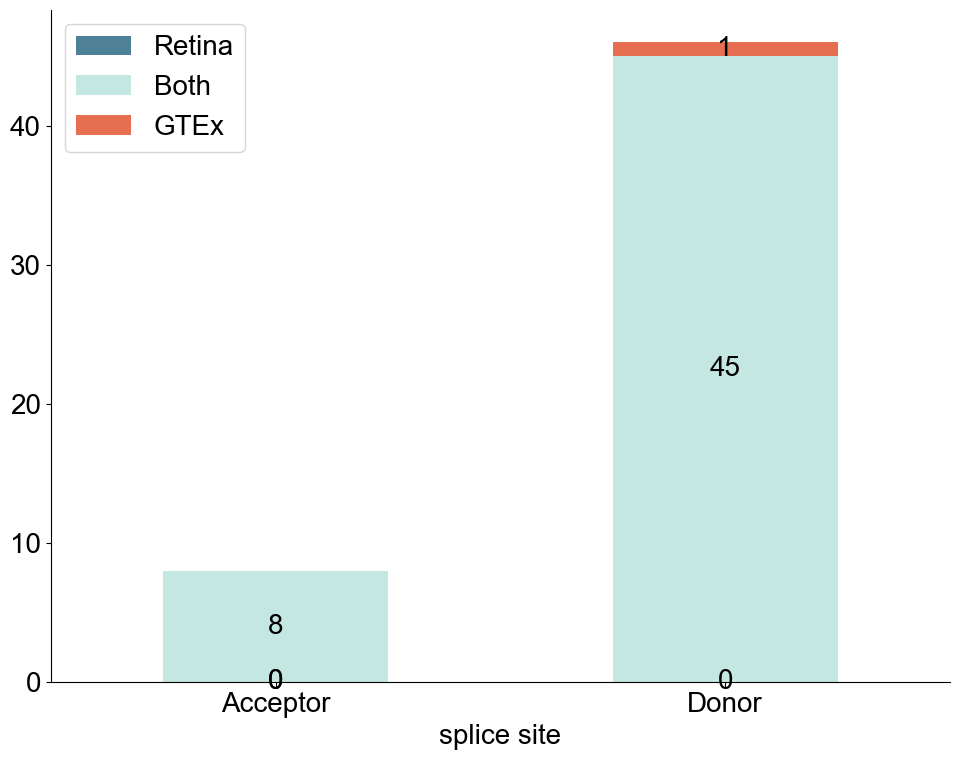

In [8]:
retina_sas = control_sas_df[control_sas_df['Retina'] >= 0.07]
gtex_sas = control_sas_df[control_sas_df['GTEx'] >= 0.20]
retina_sas = set(row['chr'] + ':' + str(row['position']) for index, row in retina_sas.iterrows())
gtex_sas = set(row['chr'] + ':' + str(row['position']) for index, row in gtex_sas.iterrows())

retina_sds = control_sds_df[control_sds_df['Retina'] >= 0.07]
gtex_sds = control_sds_df[control_sds_df['GTEx'] >= 0.19]
retina_sds = set(row['chr'] + ':' + str(row['position']) for index, row in retina_sds.iterrows())
gtex_sds = set(row['chr'] + ':' + str(row['position']) for index, row in gtex_sds.iterrows())

df = pd.DataFrame([['Acceptor',len(retina_sas - gtex_sas), len(retina_sas & gtex_sas), len(gtex_sas - retina_sas) ],
                   ['Donor', len(retina_sds - gtex_sds), len(retina_sds & gtex_sds), len(gtex_sds - retina_sds)]],
                   columns = ['splice site', 'Retina', 'Both', 'GTEx'])

plt.rcParams.update(rc)

# Create bar plot
ax = df.plot(x='splice site', kind='bar', stacked=True, color = ['#4E8098', '#C5E7E2', '#E76F51'])

# Display the plot
plt.xticks(rotation=0, ha='center', rotation_mode='anchor')

# Add data labels
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width / 2, 
            y + height / 2, 
            '{:.0f}'.format(height), 
            ha='center', 
            va='center')

# Remove black x and y axis line
sns.despine(bottom = False, left = False)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('plots/control_exons_stacked.svg',  bbox_inches='tight', dpi = 300)
plt.show()
